In [8]:
import numpy as np
import pandas as pd

from scipy.stats import entropy
from copy import deepcopy as copy

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array, as_float_array

import matplotlib.pyplot as plt

%matplotlib inline

In [125]:
class MaxentropyDichtomizationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_splits, verbose=False):
        self.n_splits = n_splits
        
        self.n_samples = None
        self.n_features = None
        self._splits = None
        self._splits_indices = None
    
    def _check_X(self, X, n_features=None):
        _X = None
        if not hasattr(X, 'dtype'):
            _X = check_array(as_float_array(X))
        _X = check_array(X)
        
        if self.n_features:
            if _X.shape[1] != self.n_features:
                raise Exception('X has {} columns while {} are expected'.format(_X.shape[1], self.n_features))
        return _X
    
    def _get_maxentropy_split(self, X):
        block_size = X.shape[0]
        ix_max_entropy = -1
        max_entropy = -1
        max_probas = None
        for i in range(1, block_size - 1):
            a = np.sum(X < X[i])
            b = np.sum(X >= X[i])

            p = np.array([a / block_size, b / block_size])
            e = -np.sum(np.log(p + 1) * p)

            if max_entropy < e:
                max_probas = p
                max_entropy = e
                ix_max_entropy = i
        
        if max_probas is None or 0 in max_probas:
            return 0, -1

        return max_entropy, ix_max_entropy

    def _dichtomize(self, X):
        _iters = np.log2(self.n_splits)
        if _iters - int(_iters) != 0:
            raise Exception('number of bins should be of a power of 2')
        
        # make first maxentropy split
        _, initial_bin = self._get_maxentropy_split(X)
        splits_current_feature = [(0, initial_bin), (initial_bin, self.n_samples - 1)]
        for i in range(int(_iters) - 1):
            # an empty list for splits in current iteration
            _splits = list()
            for j in splits_current_feature:
                entropy, index = self._get_maxentropy_split(X[j[0]: j[1]])
                if entropy == 0:
                    _splits += [(j[0], j[1])]
                else:
                    _splits += [(j[0], j[0] + index), (j[0] + index, j[1])]

            splits_current_feature = _splits
            
        return splits_current_feature
    
    def _convert(self, X, ix):
        result = list()
        for x in X.flatten():
            result.append(np.argwhere([k[0] <= x and x < k[1] for k in self._splits[ix]]))
        return np.array(result).reshape(-1, 1) 
    
    def fit(self, X):
        X = self._check_X(X)
        self.n_samples, self.n_features = X.shape
        
        self._splits = list()
        self._splits_indices = list()
        
        for ix in range(self.n_features):
            x = np.sort(X[:, ix].flatten())
            _indices = self._dichtomize(x.flatten())
            
            self._splits_indices.append(_indices)
            self._splits.append([[x[i[0]], x[i[1]]] for i in _indices])
            
            self._splits[-1][0][0] = -np.inf
            self._splits[-1][-1][1] = np.inf
            
            self._splits = np.array(self._splits)
            
        return self
    
    def transform(self, X):
        _, n_features = X.shape
        X = self._check_X(X, n_features)
        
        X_categorical = list()
        for ix in range(n_features):
            X_categorical.append(self._convert(X, ix))
            
        return np.hstack(X_categorical)

In [326]:
class MaxentropyMedianDichtomizationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_splits, verbose=False):
        self.n_splits = n_splits
        
        self.n_samples = None
        self.n_features = None
        self._splits = None
        self._splits_indices = None
    
    def _check_X(self, X, n_features=None):
        _X = None
        if not hasattr(X, 'dtype'):
            _X = check_array(as_float_array(X))
        _X = check_array(X)
        
        if self.n_features:
            if _X.shape[1] != self.n_features:
                raise Exception('X has {} columns while {} are expected'.format(_X.shape[1], self.n_features))
        return _X
    
    def _calc_entropy(self, X, split_bias):
        a = np.sum(X < split_bias)
        b = np.sum(X >= split_bias)

        p = np.array([a / X.shape[0], b / X.shape[0]])
        return -np.sum(np.log(p + 1) * p)


    def _get_maxentropy_split(self, X):
        # O(n^2)
        block_size = X.shape[0]
        ix_max_entropy = -1
        X_diff = np.diff(X)

        start_point = X.shape[0] // 2
        
        right_point = right_entropy = None
        left_point = left_entropy =None
        
        max_entropy = -1
        max_probas = None
        # define point where to start looking for
        # highest entropy
        if X_diff[start_point] == 0:
            _right_indices = np.where(X_diff[start_point:] > 0)[0]
            _left_indices = np.where(X_diff[:start_point] > 0)[0]
            
            if _right_indices.any():
                right_point = _right_indices[0] + start_point
            
            if _left_indices.any():
                left_point = _left_indices[-1]
            
            # if we have constant series
            if _right_indices is None and _left_indices is None:
                return 0, -1
            
            if right_point:
                right_entropy = self._calc_entropy(X, X[right_point])
        
            if left_point:
                left_entropy = self._calc_entropy(X, X[left_point])
        else:
            right_point = start_point + 1
            left_point = start_point - 1
            
            right_entropy = self._calc_entropy(X, X[right_point])
            left_entropy = self._calc_entropy(X, X[left_point])
            center_entropy = self._calc_entropy(X, X[start_point])
            
            if center_entropy > left_entropy and center_entropy > right_entropy:
                return center_entropy, start_point

        # if entropy at the point left to the starting point is higher
        # search for entropy maxima
        if right_point and  (not left_point or right_entropy > left_entropy):
            for j in range(right_point + 1, block_size):
                local_entropy = self._calc_entropy(X, X[j])
                if local_entropy > right_entropy:
                    right_point = j
                    right_entropy = local_entropy
                else:
                    return right_entropy, right_point
        elif left_point:
            for j in reversed(range(0, left_point - 1)):
                local_entropy = self._calc_entropy(X, X[j])
                if local_entropy > left_entropy:
                    left_point = j
                    left_entropy = local_entropy
                else:
                    return left_entropy, left_point
        
        return 0, -1

    def _dichtomize(self, X):
        # O(n^2 * log n)
        
        _iters = np.log2(self.n_splits)
        if _iters - int(_iters) != 0:
            raise Exception('number of bins should be of a power of 2')
        
        # make first maxentropy split
        _, initial_bin = self._get_maxentropy_split(X)
        splits_current_feature = [(0, initial_bin), (initial_bin, self.n_samples - 1)]
        for i in range(int(_iters) - 1):
            # an empty list for splits in current iteration
            _splits = list()
            for j in splits_current_feature:
                entropy, index = self._get_maxentropy_split(X[j[0]: j[1]])
                if entropy == 0:
                    _splits += [(j[0], j[1])]
                else:
                    _splits += [(j[0], j[0] + index), (j[0] + index, j[1])]

            splits_current_feature = _splits
            
        return splits_current_feature
    
    def _convert(self, X, ix):
        result = list()
        for x in X.flatten():
            result.append(np.argwhere([k[0] <= x and x < k[1] for k in self._splits[ix]]))
        return np.array(result).reshape(-1, 1) 
    
    def fit(self, X):
        X = self._check_X(X)
        self.n_samples, self.n_features = X.shape
        
        self._splits = list()
        self._splits_indices = list()
        
        for ix in range(self.n_features):
            x = np.sort(X[:, ix].flatten())
            _indices = self._dichtomize(x.flatten())
            
            self._splits_indices.append(_indices)
            self._splits.append([[x[i[0]], x[i[1]]] for i in _indices])
            
            self._splits[-1][0][0] = -np.inf
            self._splits[-1][-1][1] = np.inf
            
            self._splits = np.array(self._splits)
            
        return self
    
    def transform(self, X):
        _, n_features = X.shape
        X = self._check_X(X, n_features)
        
        X_categorical = list()
        for ix in range(n_features):
            X_categorical.append(self._convert(X, ix))
            
        return np.hstack(X_categorical)

In [327]:
dicht_median = MaxentropyMedianDichtomizationTransformer(32)
dicht_maxentr = MaxentropyDichtomizationTransformer(32)

In [328]:
synth = np.hstack([
    np.linspace(start=-1, stop=5, num=100),
    np.ones(100) * 5,
    5 + 3 * np.linspace(start=0, stop=5, num=100)
])

synth = pd.Series(synth).rolling(50).mean().dropna().values

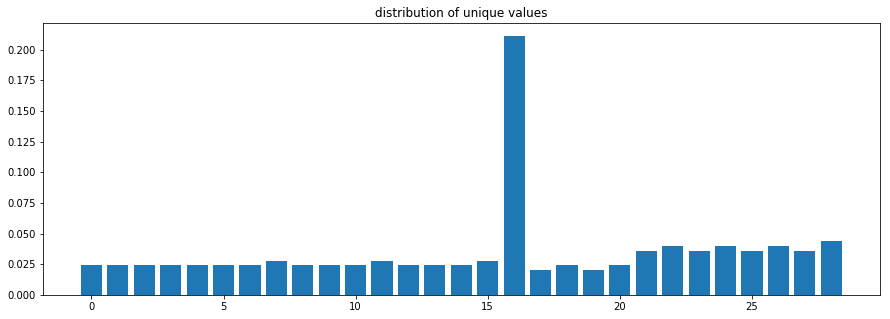

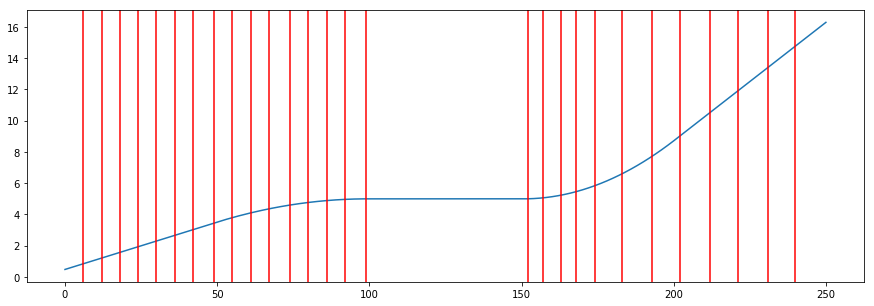

In [329]:
processed = dicht_maxentr.fit(synth.reshape(-1, 1)).transform(synth.reshape(-1, 1)).flatten()
#synth.reshape(-1, 1)
values, counts = np.unique(processed, return_counts=True)
p = counts / np.sum(counts)
-np.sum(np.log(p) * p)

plt.figure(figsize=(15, 5))
plt.bar(np.arange(p.size), p)
plt.title('distribution of unique values')
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(synth)
for i in dicht_maxentr._splits_indices[0][:-1]:
    plt.axvline(x=i[1], color='r')
plt.show()

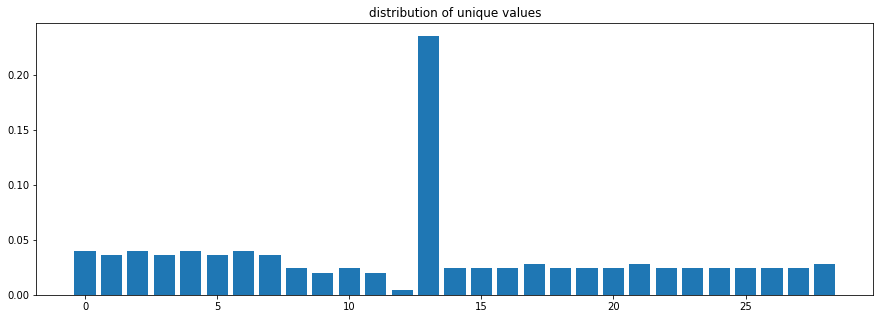

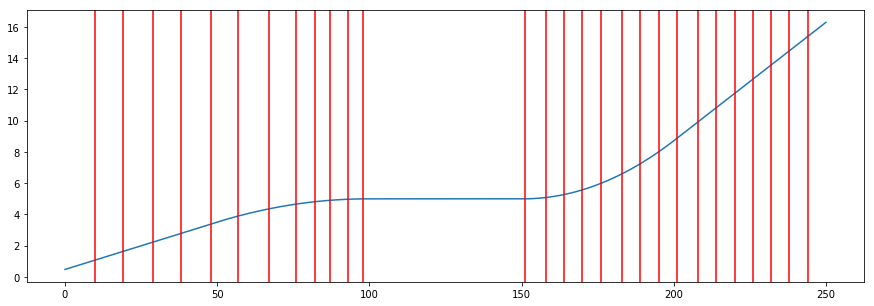

In [330]:
processed = dicht_median.fit(synth.reshape(-1, 1)).transform(synth.reshape(-1, 1)).flatten()
#synth.reshape(-1, 1)
values, counts = np.unique(processed, return_counts=True)
p = counts / np.sum(counts)
-np.sum(np.log(p) * p)

plt.figure(figsize=(15, 5))
plt.bar(np.arange(p.size), p)
plt.title('distribution of unique values')
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(synth)
for i in dicht_median._splits_indices[0][:-1]:
    plt.axvline(x=i[1], color='r')
plt.show()

# Эксперимент по бинаризации данных из разных распределений

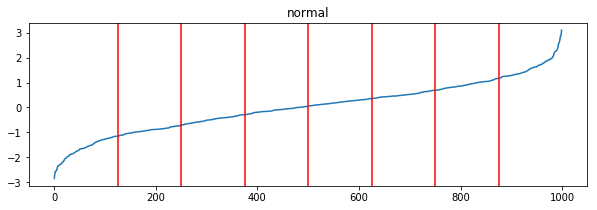

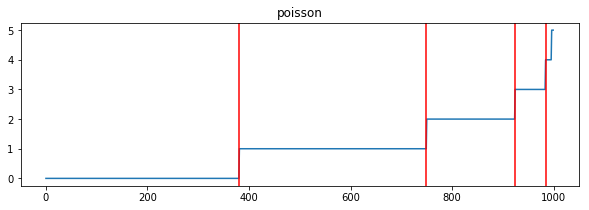

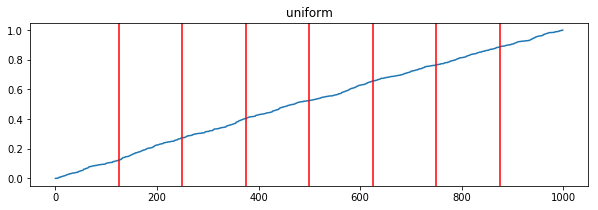

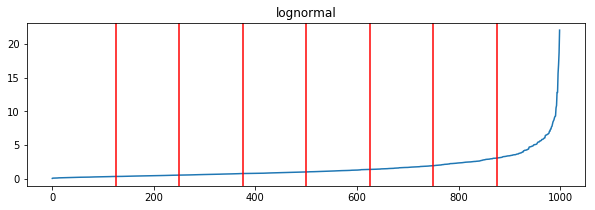

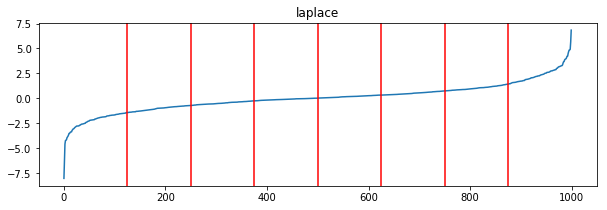

In [331]:
dichtomizer = MaxentropyMedianDichtomizationTransformer(8)

distributions = {
    "normal": np.random.normal(size=1000),
    "poisson": np.random.poisson(size=1000),
    "uniform": np.random.uniform(size=1000),
    "lognormal": np.random.lognormal(size=1000),
    "laplace": np.random.laplace(size=1000)
}

dichtomizer.fit(distributions['normal'].reshape(-1, 1))
#dichtomizer.transform(distributions['normal'].reshape(-1, 1))
for _name, _samples in distributions.items():
    dichtomizer.fit(_samples.reshape(-1, 1))
    
    plt.figure(figsize=(10, 3))
    plt.plot(np.sort(_samples))
    plt.title(_name)
    for i in dichtomizer._splits_indices[0][:-1]:
        plt.axvline(x=i[1], color='r')